<h1><center>Projet de gestion des risques </center></h1> 

## **Groupe** :
- **Mehdi Ferhat**
- **Yasmine Ouayhya**
- **Mathieu Reine**

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import hurst
import random

### Importation de la base

In [2]:
df = pd.read_csv(r"BA.csv", parse_dates=["Date"],index_col=["Date"])['Adj Close']
df

Date
2019-03-25    361.783234
2019-03-26    361.705109
2019-03-27    365.445404
2019-03-28    365.669983
2019-03-29    372.486542
                 ...    
2022-03-18    192.830002
2022-03-21    185.899994
2022-03-22    191.039993
2022-03-23    186.039993
2022-03-23    186.039993
Name: Adj Close, Length: 758, dtype: float64

### Calcul des rendements journaliers

In [3]:
returns = df.pct_change()

In [4]:
returns

Date
2019-03-25         NaN
2019-03-26   -0.000216
2019-03-27    0.010341
2019-03-28    0.000615
2019-03-29    0.018641
                ...   
2022-03-18    0.013881
2022-03-21   -0.035938
2022-03-22    0.027649
2022-03-23   -0.026173
2022-03-23    0.000000
Name: Adj Close, Length: 758, dtype: float64

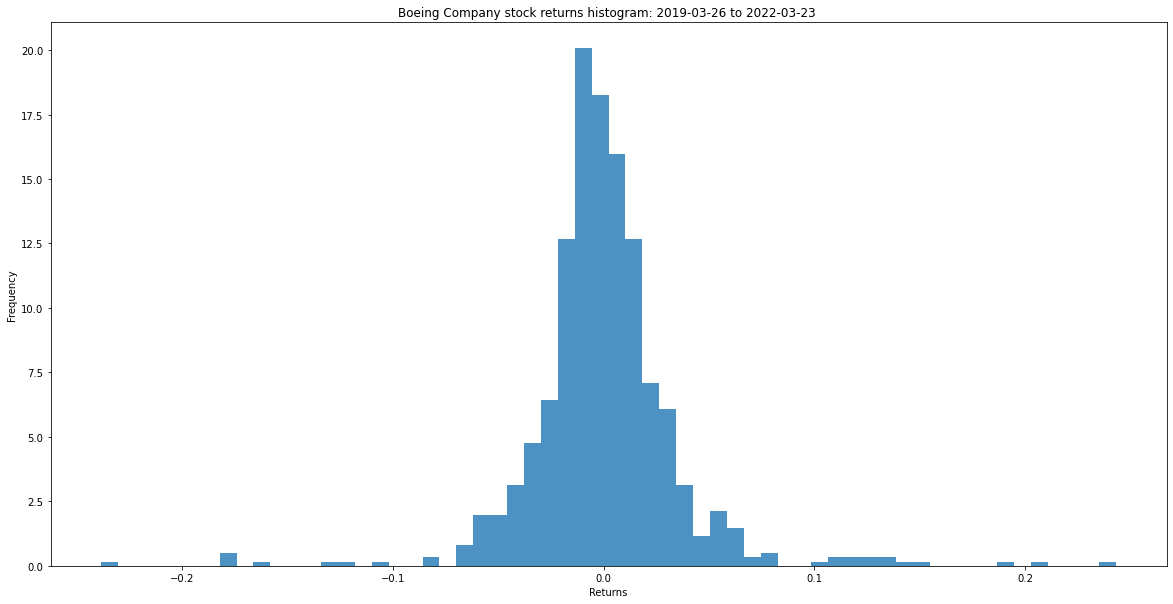

In [5]:
plt.figure(figsize=(20,10))
plt.hist(returns,bins=60,alpha=0.8,density = True)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Boeing Company stock returns histogram: 2019-03-26 to 2022-03-23 ')
plt.show()

## Question 1. Determine your VaR at 99% at a one-day horizon using alternatively the following



In [6]:
def VaR_Histo(returns, quantile):
    '''
    Cette fonction permet de calculer la VaR historique 
    
    Parameters
    ----------
    X :  Series
         La série des rendements returns
         
    quantile: float
        Le Quantile de la distribution

    Returns
    -------
    VaR : Float
        Renvoie la VaR estimée avec la méthode du quantile empirique
    '''
    returns_sorted = returns.sort_values()
    
    rank = quantile * (len(returns) + 1) - 1
    
    rank_l = int(rank)
    
    VaR = returns_sorted.iat[rank_l] + (returns_sorted.iat[rank_l + 1] - returns_sorted.iat[rank_l]) * (rank - rank_l)
    
    return VaR

In [7]:
var_histo = VaR_Histo(returns, 0.01)
var_histo*100

-11.13108803984891

In [8]:
def VaR_Parametric(returns, quantile):
    '''
    Cette fonction permet de calculer la VaR paramétrique
    
    Parameters
    ----------
    X :  Series
         La série des rendements returns
         
    quantile: float
        Le Quantile de la distribution

    Returns
    -------
    VaR : Float
         Renvoie la VaR estimée avec la méthode de la distribution paramétrique
        
    '''
    returns_sorted = returns.dropna().sort_values()
    
    returns_mean = returns_sorted.mean()
    
    return_std = returns_sorted.std()
    
    z = norm.ppf(quantile)
    
    VaR = returns_mean + return_std * z
    
    return VaR

In [9]:
var_param = VaR_Parametric(returns, 0.01)
var_param*100

-8.456332115292813

In [10]:
def VaR_MC(X):
    '''
    Cette fonction permet de calculer la VaR non paramétrique
    
    Parameters
    ----------
    X :  Series
         La série des rendements returns
         
    Returns
    -------
    VaR : Float
         Renvoie la VaR estimée avec la méthode de la distribution non paramétrique (Monte Carlo)
        
    '''
    X_sorted = X.sort_values()
    X_mean = X_sorted.mean()
    X_std = X_sorted.std()
    np.random.seed(30)
    mc_X = np.random.normal(X_mean, X_std,10000)
    var_MC = np.percentile(mc_X,0.01)
    return var_MC

In [11]:
var_MC = VaR_MC(returns)
var_MC*100

-12.945287289792585

### Question 2 : Using the estimator of Pickands, determine the parameter of the GEV function of losses and comment its value.

Text(0, 0.5, 'Estimateur de Pickands')

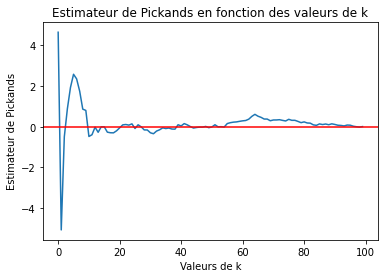

In [12]:
def Estimator_of_Pickands(X): 
    '''
    Cette fonction permet de calculer l'estimateur de Pickands pour les pertes des rendements 

    Parameters
    ----------
    X :  Series
         La série des rendements returns

    Returns
    -------
    estimator: Array
               Liste avec les valeurs de l'estimateur de Pickands pour les pertes
    '''
    X = X.where(X.values<0).dropna().sort_values().reset_index(drop=True)
    
    n = len(X)
    
    a = np.array([X[i] for i in range(0,int(n/4))])
    b = np.array([X[i] for i in range(1,int(n/2),2)])
    c = np.array([X[i] for i in range(3,int(n),4)])
    
    estimator = (1 / np.log(2)) * np.log((a-b) / (b-c))
    
    return estimator

pickands_path = Estimator_of_Pickands(returns)
plt.plot(pickands_path)
plt.axhline(y=0, color="red")

plt.title('Estimateur de Pickands en fonction des valeurs de k')
plt.xlabel('Valeurs de k')
plt.ylabel('Estimateur de Pickands')

### Question 3. Determine the VaR at 99% at a one-day horizon using the EVT approach.

In [13]:
def VAR_EVT(X,k,p):
    '''
    Cette fonction permet de calculer la VaR avec l'estimateur de Pickands pour les pertes des rendements selon l'approche EVT.

    Parameters
    ----------
    X :  Series
         La série des rendements returns
         
    k :  Integer
        Paramètre vérifiant les conditions ennoncées dans la question précédente (estimateur de Pickands)
    
    p :  Float
         Seuil alpha
        
    Returns
    -------
    var : Float
          VaR estimée avec l'approche EVT
    '''  
    X = X.dropna().sort_values()
    ksi = Estimator_of_Pickands(X)[-1]
    n = len(X)-1
    var = ((np.power(k/(n*(1-p)) , ksi) - 1)/(1 - np.power(2 , -ksi))) * (X[n-k+1] - X[n-2*k+1]) + X[n-k+1]
    return var

In [14]:
ksi = pickands_path[-1]
var_evt = VAR_EVT(returns,1,0.01)
var_evt*100

-7.622046909980335

### Question 4. What is the Leadbetter extremal index for the dataset ?

In [15]:
def binarisation(X, threshold):
    """
    Cette fonction permet de binariser la série temporelle X en fonction du seuil.
    
    Parameters
    ----------
    X : Series
        La série de rendements returns
    
    threshold : float
                Le seuil définissant la condition de binarisation
    
    Returns
    -------
    binary_X : Array
               Matrice contenant des 0 là ou les rendements sont inférieurs au seuil
               et des 1 là où les rendements lui sont supérieurs
    """
    binary_X = np.where(X.values>threshold,1,0)
    return binary_X

def blocks_declustering(X,b,threshold):
    """
    Cette fonction permet d'estimer le Leadbetter extremal index par la méthode de blocks declustering.
    
    Parameters
    ----------
    X : Series
        La série de rendements returns
        
    b : int
        Le nombre de cluster à partir desquels seront estimé le Leabetter extremal index
    
    threshold : float
                Le seuil définissant les valeurs extrêmes des rendements
                
    Returns
    -------
    float 
    Estimation du Leadbetter extremal index
    """
    n = len(X)
    k = int(n/b)
    binary_X = binarisation(X,threshold)
    sum_clusters = 0
    for i in range(1,k+1):
        if X[(i-1)*b:i*b].max()>threshold:
            sum_clusters+=1
    return sum_clusters/sum(binary_X)

threshold = returns.std()/0.99**(1/2)-returns.mean()
blocks_declustering(returns,480,threshold)    

0.01694915254237288

Text(0, 0.5, 'LeadBetter Extremal Index')

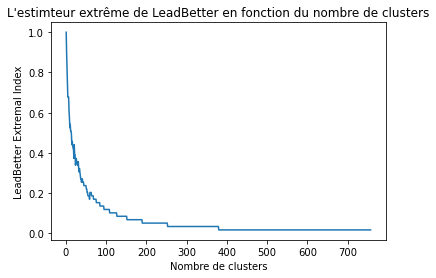

In [16]:
Extremal_indexes = [blocks_declustering(returns,i,threshold) for i in range(1,len(returns))]
plt.plot([i for i in range(1,len(returns))], Extremal_indexes)

plt.title("L'estimteur extrême de LeadBetter en fonction du nombre de clusters")
plt.xlabel('Nombre de clusters')
plt.ylabel('LeadBetter Extremal Index')

C:\Users\marein\AppData\Local\Temp/ipykernel_10444/779116071.py:61: RuntimeWarning: divide by zero encountered in log
  log_returns = np.log(returns.dropna().values)
C:\Users\marein\AppData\Local\Temp/ipykernel_10444/779116071.py:61: RuntimeWarning: invalid value encountered in log
  log_returns = np.log(returns.dropna().values)


0.035775104005849837

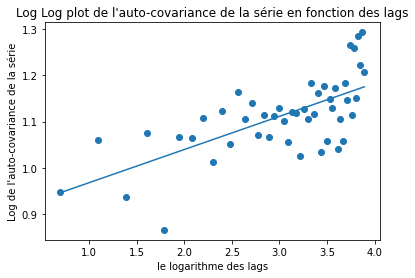

In [17]:
def linear_regression(X, Y):
    """
    Cette fonction permet d'estimer les coefficients d'une régression linéaire univariée.
    
    Parameters
    ----------
    X : Array
        La variable explicative
        
    Y : Array
        La variable cible
                
    Returns
    -------
    B0 : int
         L'intercept de la régression
    B1 : int
         Le coefficient de la variable explicative
    """
    N = len(X)
    x_mean = np.mean(X)
    y_mean = np.mean(Y)
    
    B1_num = np.sum((X - x_mean) * (Y - y_mean))
    B1_den = np.sum((X - x_mean)**2)
    B1 = B1_num / B1_den
    
    B0 = y_mean - (B1*x_mean)
    
    return (B0, B1)

def hurst_exponent_estimator(X, max_lag=20):
    """
    Cette fonction renvoie l'exposant de Hurst de la série temporelle.
    
    Parameters
    ----------
    X : Series
        La série temporelle des rendements.
        Attention /!\ Cette série doit correspondre aux log rendements.
        
    max_lag : int
              Le nombre de lag maximum sur lequel est estimé l'exposant de hurst
    
    Returns
    -------
    float
    Exposant de Hurst
    """
    
    lags = range(2, max_lag)
    tau = [np.var(np.subtract(X[lag:], X[:-lag])) for lag in lags]
    reg = linear_regression(np.log(lags), np.log(tau))
    plt.xlabel('le logarithme des lags')
    plt.ylabel("Log de l'auto-covariance de la série")
    plt.title("Log Log plot de l'auto-covariance de la série en fonction des lags")
    plt.scatter(np.log(lags), np.log(tau))
    plt.plot(np.log(lags),reg[1]*np.log(lags)+reg[0])
    return reg[1]/2

log_returns = np.log(returns.dropna().values)
log_returns = log_returns[np.logical_not(np.logical_or(np.isnan(log_returns),np.isinf(log_returns)))]
hurst_exponent_estimator(log_returns,50)

### Question 7

In [18]:
def ES(X,var):
    """
    Cette fonction renvoie l'Expected Shortfall de la série des rendements.
    
    Parameters
    ----------
    X : Series
        La série temporelle des rendements
    
    var : float
          La value at risk de la série des rendements
          
    Returns
    -------
    float
    L'Expected Shortfall de la série des rendements associée à la Value at Risk.    
    """
    X = X.dropna()
    return X[X.lt(var)].mean()

es_param = ES(returns,var_param)
es_histo = ES(returns,var_histo)
es_MC = ES(returns,var_MC)
es_evt = ES(returns,var_evt)

In [19]:
print(var_param*100,"\n",var_histo*100,"\n",var_MC*100,"\n",var_evt*100)

-8.456332115292813 
 -11.13108803984891 
 -12.945287289792585 
 -7.622046909980335


In [20]:
print(es_param*100,"\n",es_histo*100,"\n",es_MC*100,"\n",es_evt*100)

-16.31218701636732 
 -17.174761765449578 
 -17.976518232901782 
 -14.657514988420733


### Question 8.

In [21]:
train = returns[:int(0.7*len(returns))]
test = returns[int(0.7*len(returns)):]

train_sorted = train.sort_values()
train_mean = train_sorted.mean()
train_std = train_sorted.std()

In [22]:
var_hist_train = VaR_Histo(train,0.01)
var_param_train = VaR_Parametric(train,0.01)
var_MC_train = VaR_MC(train)
var_EVT_train = VAR_EVT(train,1,0.01)

test_var_hist = test[test.lt(var_hist_train)]
test_var_param = test[test.lt(var_param_train)]
test_var_MC = test[test.lt(var_MC_train)]
test_var_EVT = test[test.lt(var_MC_train)]

print("Pourcentage de valeurs de test en-deçà de la VaR historique :",test_var_hist.count()/len(test))
print("Pourcentage de valeurs de test en-deçà de la VaR paramétrique :",test_var_param.count()/len(test))
print("Pourcentage de valeurs de test en-deçà de la VaR de mon Monte-Carlo :",test_var_MC.count()/len(test))
print("Pourcentage de valeurs de test en-deçà de la VaR EVT :",test_var_EVT.count()/len(test),"\n")

es_param_train = ES(train,var_param_train)
es_hist_train = ES(train,var_hist_train)
es_MC_train = ES(train,var_MC_train)
es_EVT_train = ES(train,var_EVT_train)

test_es_hist = test[test.lt(es_hist_train)]
test_es_param = test[test.lt(es_param_train)]
test_es_MC = test[test.lt(es_MC_train)]
test_es_EVT = test[test.lt(es_EVT_train)]

print("Pourcentage de valeurs de test en-deçà de l'ES historique :",test_es_hist.count()/len(test))
print("Pourcentage de valeurs de test en-deçà de l'ES paramétrique :",test_es_param.count()/len(test))
print("Pourcentage de valeurs de test en-deçà de l'ES de Monte-Carlo :",test_es_MC.count()/len(test))
print("Pourcentage de valeurs de test en-deçà de l'ES EVT :",test_es_EVT.count()/len(test))

Pourcentage de valeurs de test en-deçà de la VaR historique : 0.0
Pourcentage de valeurs de test en-deçà de la VaR paramétrique : 0.0
Pourcentage de valeurs de test en-deçà de la VaR de mon Monte-Carlo : 0.0
Pourcentage de valeurs de test en-deçà de la VaR EVT : 0.0 

Pourcentage de valeurs de test en-deçà de l'ES historique : 0.0
Pourcentage de valeurs de test en-deçà de l'ES paramétrique : 0.0
Pourcentage de valeurs de test en-deçà de l'ES de Monte-Carlo : 0.0
Pourcentage de valeurs de test en-deçà de l'ES EVT : 0.0


In [23]:
print(var_param_train*100,"\n",var_hist_train*100,"\n",var_MC_train*100,"\n",var_EVT_train*100)

-9.484828516402812 
 -15.488138038856789 
 -14.534194126789343 
 -5.048898577093642


In [24]:
es_param_test = ES(test,var_param_train)
es_hist_test = ES(test,var_hist_train)
es_MC_test = ES(test,var_MC_train)
es_EVT_test = ES(test,var_EVT_train)

In [25]:
print(es_param_test*100,"\n",es_hist_test*100,"\n",es_MC_test*100,"\n",es_EVT_test*100)

nan 
 nan 
 nan 
 -5.678581419375381


### Question 10.

In [26]:
sample_means = []
sample_stds = []
sample_vars = []
for i in range(20000):
    random_returns = random.sample(returns.dropna().to_list(),50)
    random_returns.sort()
    sample_mean = np.mean(random_returns)
    sample_std = np.std(random_returns)
    sample_var = sample_mean + sample_std * norm.ppf(0.01)
    sample_means.append(sample_mean)
    sample_stds.append(sample_std)
    sample_vars.append(sample_var)
    

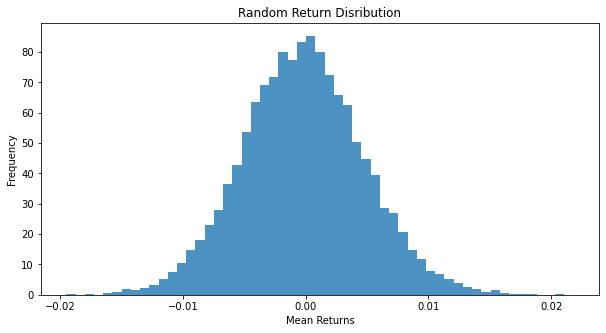

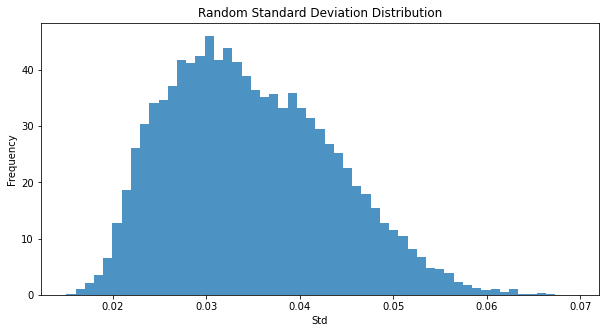

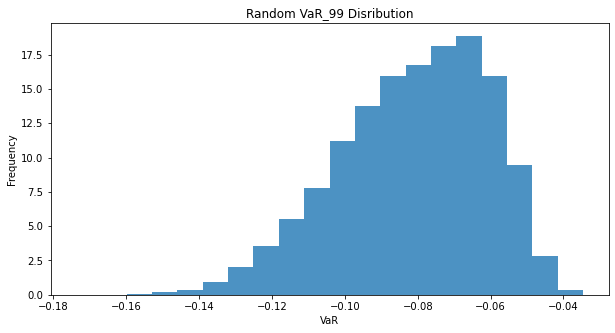

In [27]:
plt.figure(figsize=(10,5))
plt.hist(sample_means,bins='rice',alpha=0.8,density = True)
plt.title('Random Return Disribution')
plt.xlabel('Mean Returns')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10,5))
plt.hist(sample_stds,bins='rice',alpha=0.8,density = True)
plt.title('Random Standard Deviation Distribution')
plt.xlabel('Std')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10,5))
plt.hist(sample_vars,bins=20,alpha=0.8,density = True)
plt.title('Random VaR_99 Disribution')
plt.xlabel('VaR')
plt.ylabel('Frequency')
plt.show()

### Question 11

In [28]:
sample_means = []
sample_stds = []
sample_ksis = []
sample_vars = []
for i in range(20000):
    random_returns = np.random.normal(returns.dropna().mean(),returns.dropna().std(),1000)
    random_returns.sort()
    sample_mean = np.mean(random_returns)
    sample_std = np.std(random_returns)
    random_returns = pd.Series(random_returns)
    sample_ksi = Estimator_of_Pickands(random_returns)[-1]
    sample_var = VAR_EVT(random_returns,1,0.01)
    sample_means.append(sample_mean)
    sample_stds.append(sample_std)
    sample_ksis.append(sample_ksi)
    sample_vars.append(sample_var)

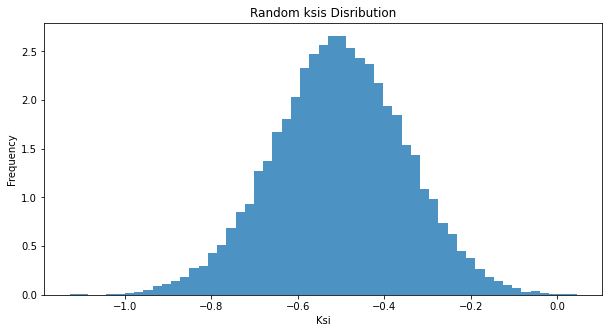

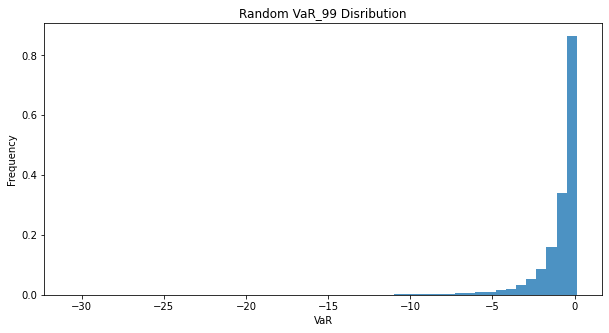

In [29]:
plt.figure(figsize=(10,5))
plt.hist(sample_ksis,bins='rice',alpha=0.8,density = True)
plt.title('Random ksis Disribution')
plt.xlabel('Ksi')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10,5))
plt.hist(sample_vars,bins=50,alpha=0.8,density = True)
plt.title('Random VaR_99 Disribution')
plt.xlabel('VaR')
plt.ylabel('Frequency')
plt.show()

### Question 13

In [30]:
sample_means = []
sample_stds = []
sample_vars = []
for i in range(20000):
    random_returns = np.random.normal(returns.dropna().mean(),returns.dropna().std(),1000)
    random_returns.sort()
    sample_mean = np.mean(random_returns)
    sample_std = np.std(random_returns)
    sample_var = np.percentile(random_returns,0.01)
    sample_means.append(sample_mean)
    sample_stds.append(sample_std)
    sample_vars.append(sample_var)

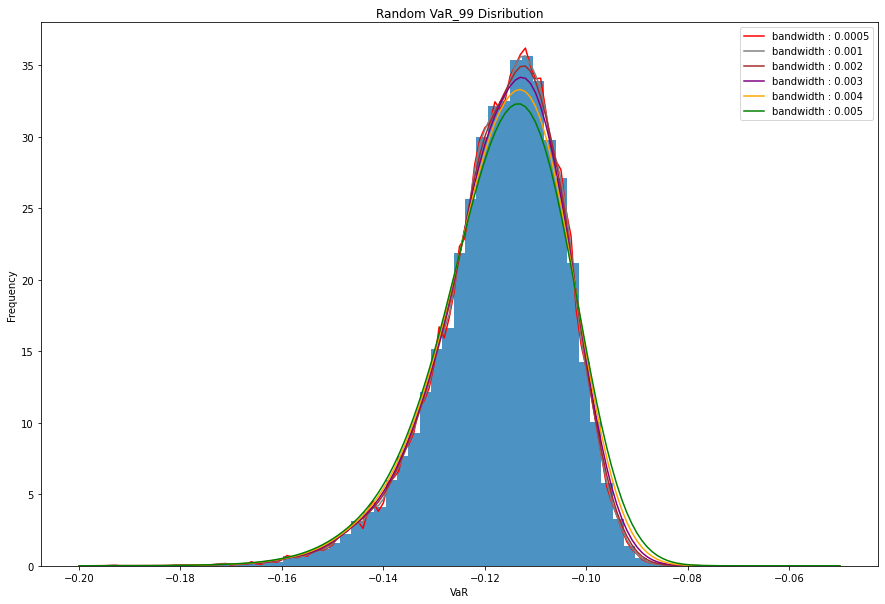

In [31]:
# Cette lambda expression renvoie la densité de probabilité d'une loi nourmale d'espérance nulle et 
# de variance égale à 1 évaluée en x.
# Il s'agit d'un kernel Gaussien.
kgauss = lambda x : 1/np.sqrt(2*np.pi) * np.exp(-1/2 * x**2) 

# Cette lambda expression renvoie l'estimation de la densité de probabilité
# des observations évaluée en x avec une bandwidth h et un kernel K.
 
D = lambda x, h, xi, K : 1/(len(xi) * h) * sum(K((x - xi) / h))


bandwidths = [0.0005, 0.001, 0.002, 0.003, 0.004, 0.005]
definition = np.arange(-0.2,-0.05,0.001)

plt.figure(figsize=(15,10))
plt.hist(sample_vars,bins=50,alpha=0.8,density = True)
colors = ["red","grey","brown","purple","orange","green"]
zip(colors,bandwidths)
for color,bandwidth in zip(colors,bandwidths):
    dens = [D(xstep, bandwidth, sample_vars, kgauss) for xstep in definition]
    plt.plot(definition, dens, label = "bandwidth : "+str(bandwidth),color=color)
plt.legend()
plt.title('Random VaR_99 Disribution')
plt.xlabel('VaR')
plt.ylabel('Frequency')
plt.show()

### Question 14.

In [32]:
def VaRs_diameter(X, p):
    """
    Cette fonction renvoie le diamètre de la Value at Risk
    
    Parameters
    ----------
    X : Array
        La série temporelle des rendements
    p : float
        Le seuil de confiance
    
    Returns
    -------
    float
    Le diamètre de la Value at Risk
    """
    var_hist = VaR_Histo(X,p)
    var_para = VaR_Parametric(X,p)
    var_MC = VaR_MC(X)
    var_EVT = VAR_EVT(X,1,p)
    VaRs = [var_hist,var_para,var_MC,var_EVT]
    var_diameter =  np.max(VaRs)-np.min(VaRs)
    return var_diameter

In [33]:
VaRs_diameter(returns,0.01)

0.053232403798122496

In [34]:
def ESs_diameter(X, p):
    '''
    Cette fonction retourne le diamètre des ESs
    
    Parameters
    ----------
    X :  Series
         La série des rendements returns
         
    p :  Float
         Seuil de confiance
    
    Returns
    -------
    float
    Le diamètre de l'Expected Shortfall
    """
    '''
    es_hist = ES(X,VaR_Histo(X,p))
    es_para = ES(X,VaR_Parametric(X,p))
    es_MC = ES(X,VaR_MC(X))
    es_EVT = ES(X,VAR_EVT(X,1,p))
    ESs = [es_hist,es_para,es_MC,es_EVT]
    es_diameter =  np.max(ESs)-np.min(ESs)
    return es_diameter

In [35]:
ESs_diameter(returns,0.01)

0.033190032444810474

### Question 15

In [36]:
def safest_risk_measure(X,p):  
    '''
    Cette fonction retourne la mesure du risque avec le diamètre le plus 
    faible 
    
    Parameters
    ----------
    X :  Series
         La série des rendements returns
         
    p :  Float
         Seuil de confiance
    '''
    var_diameter = VaRs_diameter(X,p)
    es_diameter = ESs_diameter(X,p)
    if var_diameter < es_diameter:
        safest_measure = {"safest_risk_measure":"Value at Risk", "diameter":var_diameter}
    elif var_diameter > es_diameter:
        safest_measure = {"safest_risk_measure":"Expected Shortfall", "diameter":es_diameter}
    else:
        safest_measure = {"safest_risk_measure":"both","diameter":var_diameter}
    return safest_measure

In [37]:
list_conf = [0.1,0.05,0.02,0.01,0.005,0.001,0.0001]
for p in list_conf:
    safest_measure = safest_risk_measure(returns,p)
    print("confidence level:", 1-p,safest_measure)

confidence level: 0.9 {'safest_risk_measure': 'Value at Risk', 'diameter': 0.09554987834908965}
confidence level: 0.95 {'safest_risk_measure': 'Value at Risk', 'diameter': 0.08139257132511307}
confidence level: 0.98 {'safest_risk_measure': 'Expected Shortfall', 'diameter': 0.059941238463008986}
confidence level: 0.99 {'safest_risk_measure': 'Expected Shortfall', 'diameter': 0.033190032444810474}
confidence level: 0.995 {'safest_risk_measure': 'Expected Shortfall', 'diameter': 0.053784445095056505}
confidence level: 0.999 {'safest_risk_measure': 'both', 'diameter': 0.1755707885030155}
confidence level: 0.9999 {'safest_risk_measure': 'both', 'diameter': 0.21444945852026637}


### Question 16

In [42]:
def compute_VaRs(X,p):
    '''
    Cette fonction permet de calculer les différentes méthodes de VaR à la 
    série d'entrée
    
    Parameters
    ----------
    X :  Series
         La série des rendements returns
         
    p :  float
         Seuil de confiance
    '''
    var_hist = VaR_Histo(X,p)
    var_para = VaR_Parametric(X,p)
    var_MC = VaR_MC(X)
    var_EVT = VAR_EVT(X,1,p)
    VaRs = {"Hist":var_hist,"Para":var_para,"MC":var_MC,"EVT":var_EVT}
    return VaRs

def compute_ESs(X,p):
       
    '''
    Cette fonction permet de calculer l'extension des différentes méthodes 
    de VaR à l'ES sur la série
    
    Parameters
    ----------
    X :  Series
         La série des rendements returns
         
    p : float
         Seuil de confiance
    '''
    es_hist = ES(X,VaR_Histo(X,p))
    es_para = ES(X,VaR_Parametric(X,p))
    es_MC = ES(X,VaR_MC(X))
    es_EVT = ES(X,VAR_EVT(X,1,p))
    ESs = {"Hist":es_hist,"Para":es_para,"MC":es_MC,"EVT":es_EVT}
    return np.array(ESs)

In [43]:
def white_noise_imputation(X,std):
    '''
    Cette fonction permet d'ajouter un bruit blanc à la série d'entrée
    
    Parameters
    ----------
    X :  Series
         La série des rendements returns
         
    std: float
         Standard Deviation - Ecart type
    '''
    X = X.dropna()
    np.random.seed(30)
    white_noise = np.random.normal(0,std,len(X))
    X += white_noise
    return X

returns_and_wn = white_noise_imputation(returns,0.01)

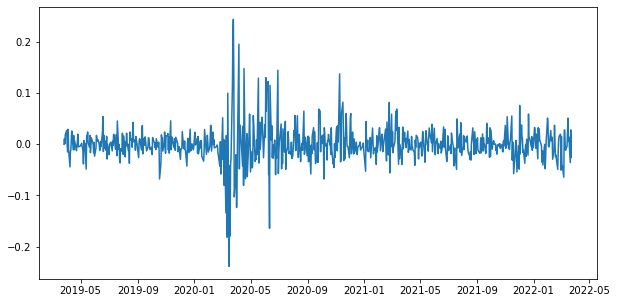

In [44]:
plt.figure(figsize=(10,5))
plt.plot(returns.dropna())

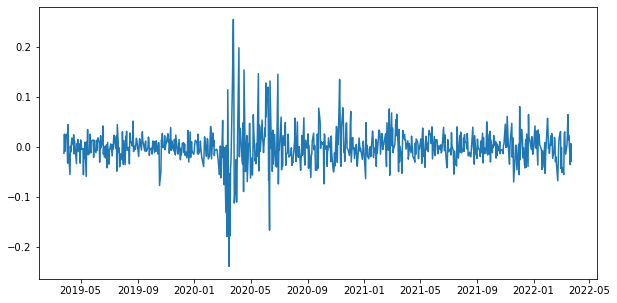

In [45]:
plt.figure(figsize=(10,5))
plt.plot(returns_and_wn)

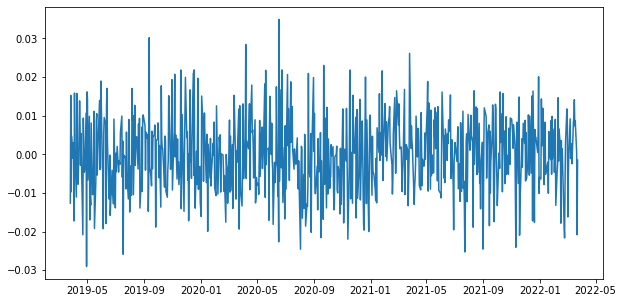

In [46]:
plt.figure(figsize=(10,5))
plt.plot(returns_and_wn-returns.dropna())

In [47]:
def most_robust_with_wn_var(X,p):
    '''
    Cette fonction renvoie la méthode de calcul de VaR la plus robuste
    
    Parameters
    ----------
    X :  Series
         La série des rendements returns
         
    p: float
       Le Quantile de la distribution
    '''
    diff = {"Hist" : [],"Para" : [],"MC" : [],"EVT" : []}
    for std in np.arange(0,0.1,0.005):
        X_and_wn = white_noise_imputation(X,std)
        VaRs = compute_VaRs(X,p)
        VaRs_wn = compute_VaRs(X_and_wn,p)
        for key in diff.keys():
            diff[key].append(abs(VaRs[key]-VaRs_wn[key]))
    average_impacts = {"Hist" : 0,"Para" : 0,"MC" : 0,"EVT" : 0}
    for key in diff.keys():
        average_impacts[key] = np.mean(diff[key])
    method = min(average_impacts, key=average_impacts.get)
    average_impact = min(average_impacts.values())
    most_robust_var = {"method":method, "average_impact":average_impact}
    return most_robust_var

In [48]:
print(most_robust_with_wn_var(returns,0.01))

{'method': 'Hist', 'average_impact': 0.03929362503033088}


### Question 17

In [49]:
def haar_denoising(X):
    '''
    Cette fonction permet de débruiter une série à l'aide de la méthode 
    de Haar
    
    Parameters
    ----------
    X :  Series
         La série des rendements returns bruités
    '''
    def lowFreq(n , a):
        return (a[n] + a[n-1]) / 2
    
    if len(X) % 2 :
        X = pd.concat([X,pd.Series([0])])
        
    father = np.array([])
    for n in range(1 , len(X),2):
        father = np.append(father,[lowFreq(n , X)])

    return pd.Series(father,index=np.arange(0,len(father),1))
returns_denoised = haar_denoising(returns)
print(returns_denoised)

0           NaN
1      0.005478
2      0.022587
3     -0.008699
4      0.009487
         ...   
374   -0.008069
375    0.037742
376    0.010115
377   -0.004145
378   -0.013086
Length: 379, dtype: float64


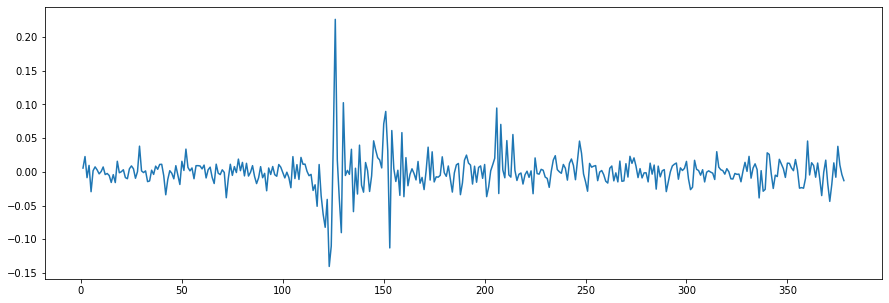

In [50]:
plt.figure(figsize=(15,5))
plt.plot(returns_denoised)

### Question 18

In [51]:
def most_robust_without_wn_var(X,p):
    
    diff = {"Hist" : [],"Para" : [],"MC" : [],"EVT" : []}
    X_no_wn = haar_denoising(X)
    VaRs = compute_VaRs(X,p)
    VaRs_no_wn = compute_VaRs(X_no_wn,p)
    for key in diff.keys():
        diff[key].append(abs(VaRs[key]-VaRs_no_wn[key]))
    average_impacts = {"Hist" : 0,"Para" : 0,"MC" : 0,"EVT" : 0}
    for key in diff.keys():
        average_impacts[key] = np.mean(diff[key])
    method = min(average_impacts, key=average_impacts.get)
    average_impact = min(average_impacts.values())
    most_robust_var = {"method":method, "average_impact":average_impact}
    return most_robust_var

In [52]:
print(most_robust_without_wn_var(returns,0.01))

{'method': 'Hist', 'average_impact': 0.017089114849668977}
